In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [94]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree,preprocessing,metrics,linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GridSearchCV

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
display(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
#somando  todos os nulos por coluna
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#Verificar Outliers valores fora do padrão como 0.4 na coluna Age 
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#Descobrir se as 418 pessoas sobrevivram ou não ao desastre 
display(test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [9]:
#temos 418 entries dados não nulos
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
#Soma dos dados nulos
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#Opções tratar os dados nos dataframes de treino e teste

In [12]:
#Unir os dataFames utilizei .concat, pois o .append estava com erro
passengerId = test['PassengerId']

titanic_df = pd.concat([train,test],ignore_index = True)


In [13]:
#Separar até onde vai o Df de treino e onde começa o df de teste
len(titanic_df) - len(test)

891

In [14]:
train_index = len(train)
test_index = len(titanic_df) - len(test)

In [15]:
display(titanic_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [16]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [17]:
#Tratar o Df menos o Survived
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [18]:
#Criando um novo dataFrame para não precisar colocar os dados no df principal e tratar somente das colunas que interessam

df = pd.DataFrame()

#Coluna Survived

In [19]:
#Opções que temos na coluna Survived n unique valores únicos (diferentes)
titanic_df['Survived'].nunique()

2

In [20]:
# unique para saber quais são os valores únicos
titanic_df['Survived'].unique()

array([ 0.,  1., nan])

In [21]:
# Função para somar quantos nulos temos na coluna survived
titanic_df['Survived'].isnull().sum()

418

In [22]:
#quantos são os valores das pessoas que sobreviveram ou que sobreviveram ao desastre
titanic_df['Survived'].value_counts()

Survived
0.0    549
1.0    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

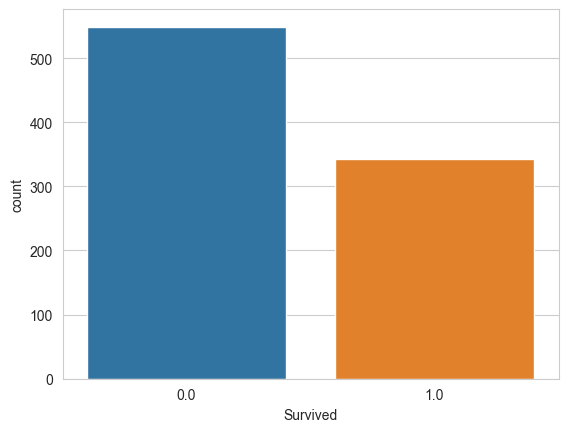

In [23]:
#plotando gráfico dos sobreviventes e dos não sobreviventes
sns.countplot(data= titanic_df, x = 'Survived')

Quantidade de valores únicos: 2

 Quais são os valores únicos: [ 0.  1. nan]

 Quantidade de valores nulos: 418

 Quantidade por opção: 
 Survived
0.0    549
1.0    342
Name: count, dtype: int64


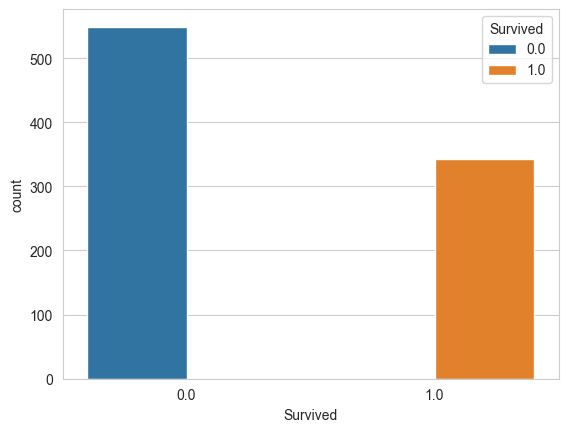

In [24]:
#Função count modelo do gráfico acima, count está como true para utilizar o gráfico acima
def titanic_function(data,column,count = True):
    print(f'Quantidade de valores únicos: {data[column].nunique()}')
    print(f'\n Quais são os valores únicos: {data[column].unique()}')
    print(f'\n Quantidade de valores nulos: {data[column].isnull().sum()}')
    print(f'\n Quantidade por opção: \n {data[column].value_counts()}')

    if count == True:
        sns.countplot(data = data, x= column, hue = 'Survived')
    else:
        sns.displot(data[column],kde = True)

#Titanic_df está relacionada ao "data", column está ligado a coluna 'Survived
titanic_function(titanic_df,'Survived')

In [25]:
#DataFame novo com apenas  coluna com o dataFrame de treino e o de Teste
df['Survived'] = titanic_df['Survived']
display(df)

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1304,NaN
1305,NaN
1306,NaN
1307,NaN


### PClas
Análise com Pclass

Quantidade de valores únicos: 3

 Quais são os valores únicos: [3 1 2]

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 Pclass
3    709
1    323
2    277
Name: count, dtype: int64


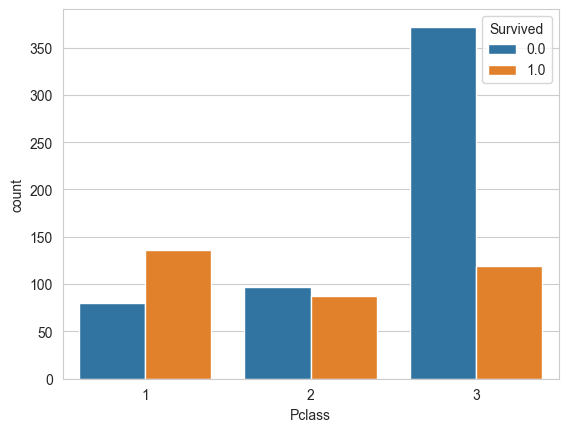

In [26]:
titanic_function(titanic_df,'Pclass')

In [27]:
df['Pclass'] = titanic_df['Pclass']
display(df)

,Survived,Pclass
0,0.0,3
1,1.0,1
2,1.0,3
3,1.0,1
4,0.0,3
...,...,...
1304,NaN,3
1305,NaN,1
1306,NaN,3
1307,NaN,3


### Analisando a coluna 'Sex'

Quantidade de valores únicos: 2

 Quais são os valores únicos: ['male' 'female']

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 Sex
male      843
female    466
Name: count, dtype: int64


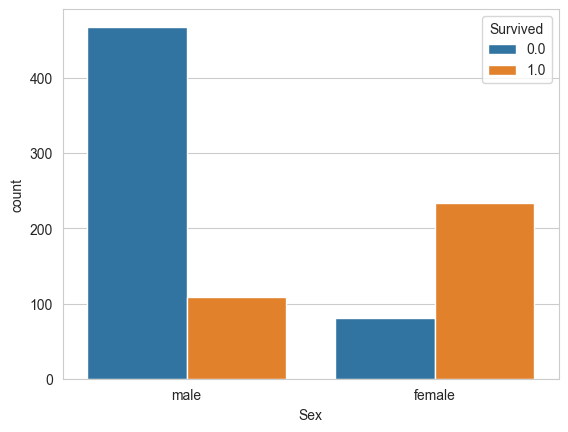

In [28]:
titanic_function(titanic_df,'Sex')

In [29]:
#Transformando a string 'male' e 'female' em  int 0/1
#exemplo como usar a função .map

titanic_df ['Sex'] = titanic_df['Sex'].replace (['male','female'],[0,1]) 
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,S


Quantidade de valores únicos: 2

 Quais são os valores únicos: [0 1]

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 Sex
0    843
1    466
Name: count, dtype: int64


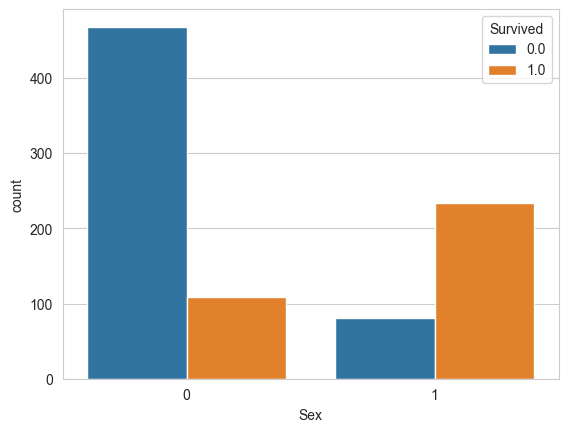

In [30]:
titanic_function(titanic_df,'Sex')

In [31]:
df['Sex'] = titanic_df['Sex']
df

,Survived,Pclass,Sex
0,0.0,3,0
1,1.0,1,1
2,1.0,3,1
3,1.0,1,1
4,0.0,3,0
...,...,...,...
1304,NaN,3,0
1305,NaN,1,1
1306,NaN,3,0
1307,NaN,3,0


### Coluna Age

In [32]:
#Póxima coluna: Age
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


Quantidade de valores únicos: 98

 Quais são os valores únicos: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]

 Quantidade de valores nulos: 263

 Quantidade por opção: 
 Age
24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
        ..
23.5     1
70.5     1
55.5     1
20.5     1
38.5     1
Name: count, Length: 98, dtype: int64


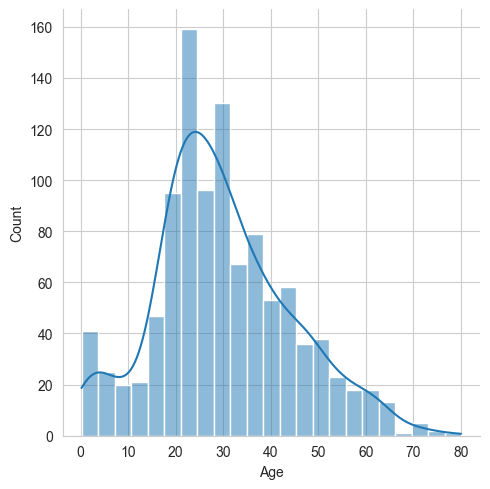

In [33]:
# Precisa utilizar o displot para não poluir a imagem do gráfico por isso o false
titanic_function(titanic_df,'Age',False)

In [34]:
# Temos 263 valores nulos no campo idade, precisam ser tratados, porém não será adequado utilizar a média como no exemplo, pois são muitos valores nulos
titanic_df['Age'].mean()

29.881137667304014

In [35]:
# Selecionar apenas as colunas numéricas do DataFrame, pois não compara strings

numeric_columns = titanic_df.select_dtypes(include='number')

In [36]:
# Calculando a correlação entre as colunas numéricas
numeric_columns.corr()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.408106,0.060832,0.018322,-0.558629
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.063645,0.109609,0.213125,0.185523
Age,0.028814,-0.077221,-0.408106,-0.063645,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,0.213125,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.185523,0.178740,0.160238,0.221539,1.000000


In [37]:
# Modificações das idades   que estão nulas de acordo com a idade média referente as classes
media_age_class1= titanic_df[titanic_df['Pclass'] == 1]['Age'].mean()
print(f'Média de idade 1° classe',media_age_class1)

media_age_class2= titanic_df[titanic_df['Pclass'] == 2]['Age'].mean()
print(f'Média de idade 2° classe',media_age_class2)

media_age_class3= titanic_df[titanic_df['Pclass'] == 3]['Age'].mean()
print(f'Média de idade 3° classe',media_age_class3)

Média de idade 1° classe 39.15992957746479
Média de idade 2° classe 29.506704980842912
Média de idade 3° classe 24.81636726546906


In [38]:
#Alterando valores nulos pela média de cada classe
for i in titanic_df.index:
    if pd.isnull(titanic_df['Age'][i]):
        if titanic_df['Pclass'][i] == 1:
            titanic_df.at[i, 'Age'] = round(titanic_df.loc[titanic_df['Pclass'] == 1, 'Age'].mean())
        elif titanic_df['Pclass'][i] == 2:
            titanic_df.at[i, 'Age'] = round(titanic_df.loc[titanic_df['Pclass'] == 2, 'Age'].mean())
        elif titanic_df['Pclass'][i] == 3:
            titanic_df.at[i, 'Age'] = round(titanic_df.loc[titanic_df['Pclass'] == 3, 'Age'].mean())
    else:
        pass

In [39]:
titanic_df[titanic_df['Pclass']==1]['Age'].isnull().sum()

0

In [40]:
#Fazer um for loop para passar em todas as classes, utilizo a função .unique para que fique dentro do array:
#Percebemos que dependendo da classe a idade varia bastante
for i in sorted (titanic_df['Pclass'].unique()):
    print(f'Pessoas da {i}ª classe tem a média de idade de: {titanic_df[titanic_df["Pclass"] == i]["Age"].mean():.2f}')


Pessoas da 1ª classe tem a média de idade de: 39.14
Pessoas da 2ª classe tem a média de idade de: 29.54
Pessoas da 3ª classe tem a média de idade de: 24.87


#SibSp (irmãos|irmãs|esposo|esposa)

Quantidade de valores únicos: 7

 Quais são os valores únicos: [1 0 3 4 2 5 8]

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64


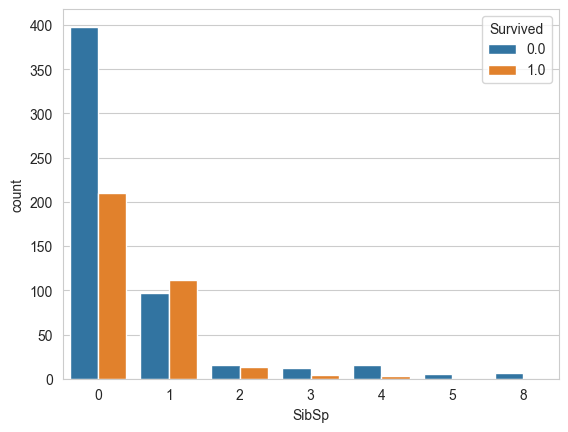

In [41]:
#Temos como a marioria das pessoas que foram sozinhas como 0 - 891 do que pessoas acompanhadas
titanic_function(titanic_df,'SibSp')

### Análise coluna Parch  (Parents and childs)

Quantidade de valores únicos: 8

 Quais são os valores únicos: [0 1 2 5 3 4 6 9]

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64


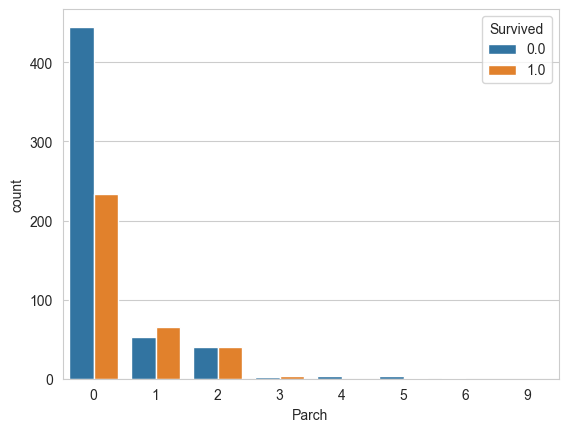

In [42]:
#Observando os valores da coluna Parch, percebemos que temos 0 valores nulos e, valor mais repetido é o 0
titanic_function(titanic_df,'Parch')

In [43]:
df['Parch'] = titanic_df['Parch']
df

,Survived,Pclass,Sex,Parch
0,0.0,3,0,0
1,1.0,1,1,0
2,1.0,3,1,0
3,1.0,1,1,0
4,0.0,3,0,0
...,...,...,...,...
1304,NaN,3,0,0
1305,NaN,1,1,0
1306,NaN,3,0,0
1307,NaN,3,0,0


### Criando uma coluna nova om os dados do tamanho da familia unindo a coluna SIbSP e Parch

In [44]:
# Coluna nova chamada Family Size somando a pessoa mais o acompanhante, por isso +1.
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] +1

In [45]:
# Podemos observar a coluna nova FamilySize somando SibSp com Parch
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [46]:
df['FamilySize'] = titanic_df['FamilySize']
df

,Survived,Pclass,Sex,Parch,FamilySize
0,0.0,3,0,0,2
1,1.0,1,1,0,2
2,1.0,3,1,0,1
3,1.0,1,1,0,2
4,0.0,3,0,0,1
...,...,...,...,...,...
1304,NaN,3,0,0,1
1305,NaN,1,1,0,1
1306,NaN,3,0,0,1
1307,NaN,3,0,0,1


### Analisando a coluna Fare (Preço da Tarifa)

Quantidade de valores únicos: 281

 Quais são os valores únicos: [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.3125  61.3792   7.7333  69.55    16.1
  15.75    20.525   55.      25.925   33.5     30.6958  25.4667  28.7125
   0.      

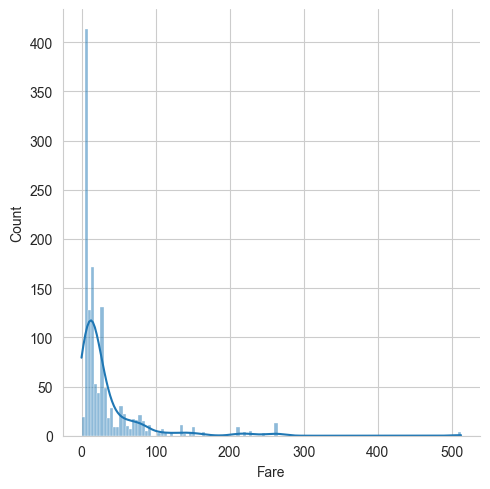

In [47]:
titanic_function(titanic_df,'Fare',False)

### Investigar onde está o valor nulo da análise acima:  Quantidade de valores nulos: 1

In [48]:
titanic_df [titanic_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,1


### Verificar a média que as pessoas da 3ª classe pagaram, e através da função fillna com base na média da classe específica.

In [49]:
# Pela função .mean() verificamos a média da terceira classe onde está o valor nulo da coluna Fare
print(f'Pessoas da 3ª classe tem a média de idade de:{titanic_df[titanic_df["Pclass"] == 3] ["Fare"].mean():.2f}')
 

Pessoas da 3ª classe tem a média de idade de:13.30


In [50]:
#Valor nulo alterado pela média, verificação se o valor não existe mais valores nulos.
titanic_df["Fare"].fillna(titanic_df[titanic_df["Pclass"] ==3 ]["Fare"].mean(), inplace = True)
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
FamilySize        0
dtype: int64

In [51]:
df['Fare'] = titanic_df['Fare']
df

,Survived,Pclass,Sex,Parch,FamilySize,Fare
0,0.0,3,0,0,2,7.2500
1,1.0,1,1,0,2,71.2833
2,1.0,3,1,0,1,7.9250
3,1.0,1,1,0,2,53.1000
4,0.0,3,0,0,1,8.0500
...,...,...,...,...,...,...
1304,NaN,3,0,0,1,8.0500
1305,NaN,1,1,0,1,108.9000
1306,NaN,3,0,0,1,7.2500
1307,NaN,3,0,0,1,8.0500


### Análise da coluna Cabin

In [52]:
#1014 valores nulos na Coluna Cabin
titanic_df['Cabin'].isnull().sum()

1014

### Podemos utilizar a letra antes do número para verificar se as pessoas estavam proximas ao bote salva vidas, mas ainda temos muitos valores nulos nessa coluna

In [53]:
#Valores únicos:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Análise Coluna Embarked

Quantidade de valores únicos: 3

 Quais são os valores únicos: ['S' 'C' 'Q' nan]

 Quantidade de valores nulos: 2

 Quantidade por opção: 
 Embarked
S    914
C    270
Q    123
Name: count, dtype: int64


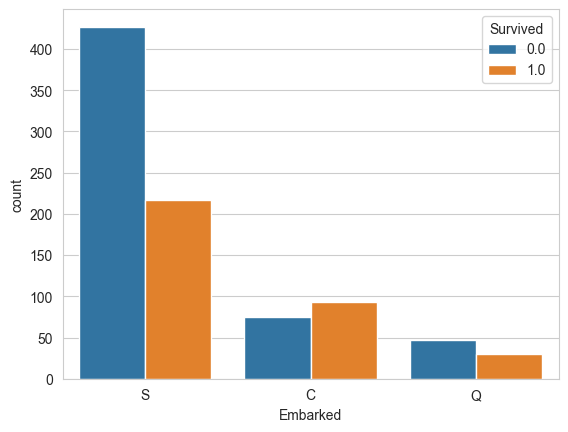

In [54]:
#Observamos que temos 3 opções de portão: S|C|Q
#A maioria das pessoas que embarcaram pelo portão S não sobreviveram.
titanic_function (titanic_df,'Embarked')

### Média das pessoas sobreviventes em relação ao portão de embarque

In [55]:
#Analisando todas as pessoas que entraram pelo portão S|C|Q
print (f'Apenas:  {titanic_df[titanic_df["Embarked"] == "S"]["Survived"].mean():.2f} % das pessoas sobreviveram do portão S')
print (f'Apenas:  {titanic_df[titanic_df["Embarked"] == "Q"]["Survived"].mean():.2f} % das pessoas sobreviveram do portão Q')
print (f'Apenas:  {titanic_df[titanic_df["Embarked"] == "C"]["Survived"].mean():.2f} % das pessoas sobreviveram do portão C')

Apenas:  0.34 % das pessoas sobreviveram do portão S
Apenas:  0.39 % das pessoas sobreviveram do portão Q
Apenas:  0.55 % das pessoas sobreviveram do portão C


### Com base na classe comparamos com a média das pessoas que sobreviveram  com a sua classe (Pclass) para obter uma estimativa sobre qual classe a pessoa pertencia

In [56]:
print (f'A média das pessoas estavam entre {titanic_df[titanic_df["Embarked"] == "S"]["Pclass"].mean():.2f} ª classe, no portão S')
print (f'A média das pessoas estavam entre {titanic_df[titanic_df["Embarked"] == "Q"]["Pclass"].mean():.2f} ª classe, no portão Q')
print (f'A média das pessoas estavam entre {titanic_df[titanic_df["Embarked"] == "C"]["Pclass"].mean():.2f} ª classe, no portão C')

A média das pessoas estavam entre 2.35 ª classe, no portão S
A média das pessoas estavam entre 2.89 ª classe, no portão Q
A média das pessoas estavam entre 1.85 ª classe, no portão C


In [57]:
#Analisando em qual classe existem os valores nulos
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1


### Alterar os dois valores nulos na coluna Embarked para o portão C

In [58]:
titanic_df['Embarked'].fillna("C",inplace = True)

In [59]:
#Verificação se os valores nulos estão existentes na coluna Embarked
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
dtype: int64

In [60]:
df['Embarked'] = titanic_df['Embarked']
df

,Survived,Pclass,Sex,Parch,FamilySize,Fare,Embarked
0,0.0,3,0,0,2,7.2500,S
1,1.0,1,1,0,2,71.2833,C
2,1.0,3,1,0,1,7.9250,S
3,1.0,1,1,0,2,53.1000,S
4,0.0,3,0,0,1,8.0500,S
...,...,...,...,...,...,...,...
1304,NaN,3,0,0,1,8.0500,S
1305,NaN,1,1,0,1,108.9000,C
1306,NaN,3,0,0,1,7.2500,S
1307,NaN,3,0,0,1,8.0500,S


### Classificar o título do nome para comparar com feminino ou masculino

In [61]:
#Verificação sobre como o MR, Mrs ou Master esté depois de uma virgula e antes de um ponto.
titanic_df['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [62]:
#Criando uma nova coluna para os dados Selecionados com uma função para separar somente o título do indivíduo 
#(Miss, Mr) que está entre a vírgula e o ponto, e a função .strip para retirar o espaço vazio antes do título.

titanic_df['Title'] = titanic_df["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [63]:
#Verificando a nova coluna criada 'Title' com os dados apresentando somente os títulos.
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,Dona
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,1,Mr


In [64]:
#Verificação sobre quantos títulos diferentes temos:
print (f'Temos {titanic_df["Title"].nunique()} títulos diferentes')
print (f'Temos os títulos: {titanic_df["Title"].unique()}')


Temos 18 títulos diferentes
Temos os títulos: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [65]:
print (f'Quantos títulos temos:\n {titanic_df["Title"].value_counts()}')


Quantos títulos temos:
 Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


In [66]:
#Alterar para pessoa a partir do Reverendo para unir os dados com a maioria acima com maior quantidade de dados.
titanic_df ['Title'] = [n if n in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Person' for n in titanic_df['Title']]

In [67]:
#Verificação para certificar que não temos valores nulos na coluna Title
print (f'Total de Valores nulos:  {titanic_df ["Title"].isnull().sum()}')
print (f'Os títulos selecionados foram: {titanic_df ["Title"].nunique()}')
print (f'Os nomes dos títulos selecionados foram: {titanic_df ["Title"].unique()}')

Total de Valores nulos:  0
Os títulos selecionados foram: 5
Os nomes dos títulos selecionados foram: ['Mr' 'Mrs' 'Miss' 'Master' 'Person']


In [68]:
#Adicionando a nova coluna Title no DataFrame
df ['Title'] = titanic_df ['Title']
df

,Survived,Pclass,Sex,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,0,2,7.2500,S,Mr
1,1.0,1,1,0,2,71.2833,C,Mrs
2,1.0,3,1,0,1,7.9250,S,Miss
3,1.0,1,1,0,2,53.1000,S,Mrs
4,0.0,3,0,0,1,8.0500,S,Mr
...,...,...,...,...,...,...,...,...
1304,NaN,3,0,0,1,8.0500,S,Mr
1305,NaN,1,1,0,1,108.9000,C,Person
1306,NaN,3,0,0,1,7.2500,S,Mr
1307,NaN,3,0,0,1,8.0500,S,Mr


Quantidade de valores únicos: 5

 Quais são os valores únicos: ['Mr' 'Mrs' 'Miss' 'Master' 'Person']

 Quantidade de valores nulos: 0

 Quantidade por opção: 
 Title
Mr        757
Miss      260
Mrs       197
Master     61
Person     34
Name: count, dtype: int64


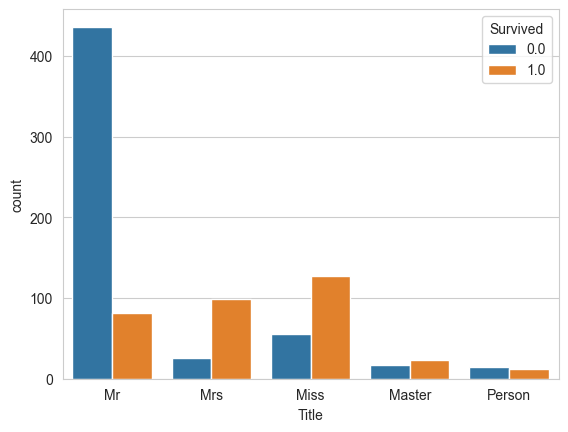

In [69]:
titanic_function(titanic_df,'Title')

In [70]:
# Abaixo estão os dfs dados unidos, com os dados tratados para depois separarmos o df de teste e o df de treino
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,Person
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,1,Mr


### Tratamento dos dados da Classe ['Pclass]

In [71]:
#Função .get_dumies divide os dados em Primeira|Segunda|Terceira classe, marcando como true (1) a opção por linha do df
pclass = pd.get_dummies (df['Pclass'], prefix= 'Pclass', drop_first= True)
title = pd.get_dummies (df['Title'], prefix= 'Pclass', drop_first= True)
embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked', drop_first = True)

In [72]:
#Dropar apenas as colunas pclass, title, embarked
#titanic_completo = pd.concat([df,pclass,title,embarked],axis=1)
titanic_completo = pd.concat([df, pclass.iloc[:], title.iloc[:], embarked.iloc[:]], axis=1)


In [73]:

print(titanic_completo.columns) 

Index(['Survived', 'Pclass', 'Sex', 'Parch', 'FamilySize', 'Fare', 'Embarked',
       'Title', 'Pclass_2', 'Pclass_3', 'Pclass_Miss', 'Pclass_Mr',
       'Pclass_Mrs', 'Pclass_Person', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [74]:
#Excluindo as coluas Pclass, Title e Embarked com a função .drop, pois já realizei o tratamento com essas colunas em FamilySize, Pclass_2,3 e Person, e Embarked pelos portões Q|S

titanic_completo.drop(['Pclass', 'Title', 'Embarked'], axis=1, inplace=True)
titanic_completo


,Survived,Sex,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Pclass_Miss,Pclass_Mr,Pclass_Mrs,Pclass_Person,Embarked_Q,Embarked_S
0,0.0,0,0,2,7.2500,False,True,False,True,False,False,False,True
1,1.0,1,0,2,71.2833,False,False,False,False,True,False,False,False
2,1.0,1,0,1,7.9250,False,True,True,False,False,False,False,True
3,1.0,1,0,2,53.1000,False,False,False,False,True,False,False,True
4,0.0,0,0,1,8.0500,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,0,1,8.0500,False,True,False,True,False,False,False,True
1305,NaN,1,0,1,108.9000,False,False,False,False,False,True,False,False
1306,NaN,0,0,1,7.2500,False,True,False,True,False,False,False,True
1307,NaN,0,0,1,8.0500,False,True,False,True,False,False,False,True


In [75]:
# Separar os dfs de teste e o de treino
train = titanic_completo[:train_index].copy()
test = titanic_completo[test_index:].copy()

In [76]:
train

,Survived,Sex,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Pclass_Miss,Pclass_Mr,Pclass_Mrs,Pclass_Person,Embarked_Q,Embarked_S
0,0.0,0,0,2,7.2500,False,True,False,True,False,False,False,True
1,1.0,1,0,2,71.2833,False,False,False,False,True,False,False,False
2,1.0,1,0,1,7.9250,False,True,True,False,False,False,False,True
3,1.0,1,0,2,53.1000,False,False,False,False,True,False,False,True
4,0.0,0,0,1,8.0500,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,0,1,13.0000,True,False,False,False,False,True,False,True
887,1.0,1,0,1,30.0000,False,False,True,False,False,False,False,True
888,0.0,1,2,4,23.4500,False,True,True,False,False,False,False,True
889,1.0,0,0,1,30.0000,False,False,False,True,False,False,False,False


In [77]:
#Converter os dados da coluna Survived como int
train['Survived'] = train['Survived'].astype(int)

In [78]:
#Separar em eixos, colunas que apenas não sobreviveu e y apenas os que sobreviveram 
x_naosobreviveu = train.drop('Survived', axis=1)
y_sobreviveu = train['Survived']

In [79]:
x_test = test.drop('Survived',axis = 1)

In [80]:
#Utilizaremos diversos tipos de ML disponíveis para encontrar os resultados
#Vc (validação cruzada)
def func_acuracia(algoritimo, x_train, y_train, vc):
    modelo = algoritimo.fit(x_train,y_train)
    acuracia = round(modelo.score(x_train, y_train)*100,2)
    train_pred = model_selection.cross_val_predict(algoritimo, x_train, y_train, cv = vc, n_jobs= -1)
    acuracia_vc = round(metrics.accuracy_score(y_train, train_pred)* 100 , 2)
    return acuracia, acuracia_vc

In [81]:
#Testando com Random Forest
acc_rf , acc_vc_rf = func_acuracia(RandomForestClassifier(), x_naosobreviveu,y_sobreviveu, 10)
print(f'Acurácia: {acc_rf}')
print(f'Acurácia Validação Cruzada: { acc_vc_rf}')


Acurácia: 93.15
Acurácia Validação Cruzada: 80.7


In [82]:
#Logistc Regression
#acc_log, acc_vc_log = func_acuracia(RandomForestClassifier(max_iter = 1000),x_naosobreviveu,y_sobreviveu,10)
acc_log, acc_vc_log = func_acuracia(RandomForestClassifier(n_estimators=1000), x_naosobreviveu, y_sobreviveu, 10)

print(f'Acurácia: {acc_log}')
print(f'Acurácia Validação Cruzada: { acc_vc_log}')

Acurácia: 93.15
Acurácia Validação Cruzada: 80.47


In [83]:
#K=nearest Neighbours 
acc_knn, acc_vc_knn = func_acuracia(KNeighborsClassifier(), x_naosobreviveu, y_sobreviveu, vc=10)
print(f'Acurácia: {acc_knn}')
print(f'Acurácia Validação Cruzada: {acc_vc_knn}')

Acurácia: 84.74
Acurácia Validação Cruzada: 78.9


In [84]:
#Gaussian Naive Bayes
acc_gaussian, acc_vc_gaussian = func_acuracia(GaussianNB(), x_naosobreviveu, y_sobreviveu, vc=10)
print(f'Acurácia: {acc_gaussian}')
print(f'Acurácia Validação Cruzada: {acc_vc_gaussian}')

Acurácia: 77.89
Acurácia Validação Cruzada: 77.67


In [85]:
#Linear Support Vector Machines (SVC)
acc_linear_svc, acc_vc_linear_svc = func_acuracia(LinearSVC(dual = False), x_naosobreviveu, y_sobreviveu, vc=10)
print(f'Acurácia: {acc_linear_svc}')
print(f'Acurácia Validação Cruzada: {acc_vc_linear_svc}')

Acurácia: 82.94
Acurácia Validação Cruzada: 82.38


In [89]:
#Stochastic Gradient Descent
acc_sgd, acc_cv_sgd = func_acuracia(SGDClassifier(),x_naosobreviveu,y_sobreviveu ,vc=10)

print(f'Acurácia: {acc_sgd}')
print(f'Acurácia Validação Cruzada: {acc_cv_sgd}')

Acurácia: 61.62
Acurácia Validação Cruzada: 70.59


In [91]:
# Decision Tree Classifiers
acc_dt, acc_cv_dt = func_acuracia(DecisionTreeClassifier(),x_naosobreviveu,y_sobreviveu ,vc=10)

print(f'Acurácia: {acc_dt}')
print(f'Acurácia Validação Cruzada: {acc_cv_dt}')

Acurácia: 93.15
Acurácia Validação Cruzada: 81.48


In [93]:
#Gradient Boost Classifier

acc_gbt, acc_cv_gbt = func_acuracia(GradientBoostingClassifier(),x_naosobreviveu,y_sobreviveu ,vc=10)

print(f'Acurácia: {acc_gbt}')
print(f'Acurácia Validação Cruzada: {acc_cv_gbt}')

Acurácia: 88.33
Acurácia Validação Cruzada: 83.61


In [95]:
params = dict(max_depth = [n for n in range(1,5)], 
              min_samples_split = [n for n in range(2,6)],
              min_samples_leaf = [n for n in range(2,6)],
              n_estimators = [n for n in range(10,50,10,)] 
)

In [96]:
gbc = GradientBoostingClassifier()

In [98]:
gbc_vc = GridSearchCV (estimator = gbc, param_grid= params, cv = 10)

In [99]:
gbc_vc.fit(x_naosobreviveu,y_sobreviveu)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40]})

In [100]:
print(f'Melhor Pontuação: {gbc_vc.best_score_}')
print(f'Melhores Parâmetros:{gbc_vc.best_estimator_}')

Melhor Pontuação: 0.8350312109862671
Melhores Parâmetros:GradientBoostingClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=3,
                           n_estimators=40)


In [ ]:
GradientBoostingClassifier_pred